# **Notebook 3: Machine Learning Model**

## Objectives

* Create ML model for predicting future CO2 levels based on current data

## Inputs

* clean_data.csv produced by Notebook 1

## Outputs

* Generates a predictive ML model for use with climate data 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Packages and Data

Import packages needed to run this notebook

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 


Import cleaned dataset

In [41]:
#set path to clean data file
path = "../raw_data/clean_data.csv"

# read data into dataframe
df_clean = pd.read_csv(path, parse_dates=['year'])

# display data types for verification
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2842 entries, 0 to 2841
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   country                         2842 non-null   object        
 1   iso_code                        2842 non-null   object        
 2   year                            2842 non-null   datetime64[ns]
 3   primary_energy_consumption      2842 non-null   float64       
 4   co2                             2842 non-null   float64       
 5   co2_including_luc               2793 non-null   float64       
 6   total_ghg                       2842 non-null   float64       
 7   co2_growth_abs                  2842 non-null   float64       
 8   co2_growth_prct                 2842 non-null   float64       
 9   co2_per_capita                  2842 non-null   float64       
 10  co2_per_gdp                     2842 non-null   float64       
 11  ener

# Using Linear Regression to Predict Global CO2 levels over time

### Create train and test data sets
First I created a dataset with the columns of interest, with values summed by year.<br>
From the visualisations I know that per capita CO2 is falling over time, but it would be good to visualise total CO2 levels as this is what the model will be predicting.<br>
(Steps modified from https://www.geeksforgeeks.org/machine-learning/step-by-step-guide-to-modeling-time-series-data-using-linear-regression/)

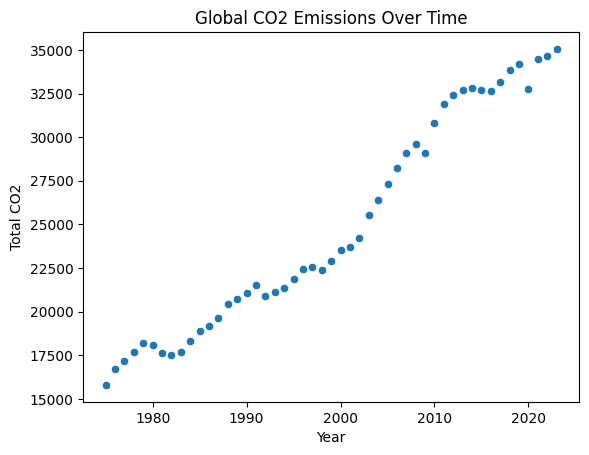

In [42]:
# create dataset with year and co2 columns only, co2 is summed across all countries
df_global = df_clean[['year', 'co2']].groupby('year', as_index=False).sum()

sns.scatterplot(df_global, x='year', y='co2')
plt.title("Global CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total CO2")
#plt.xticks({df_global['year'] : df_global['year'].dt.year})
plt.show()

This graph shows that global CO2 levels are increasing over time.

Next I split our data into a train and test set, this lets me hold back some unseen data to test the model on after training.<br>

In [43]:
# convert year (datetime) to numeric ordinal for regression
df_global['year'] = df_global['year'].map(pd.Timestamp.toordinal)

# prepare features and target
X = df_global[['year']]
y = df_global['co2']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42, shuffle=False
)

print(
	"* Train set:",
	X_train.shape,
	y_train.shape,
	"\n* Test set:",
	X_test.shape,
	y_test.shape,
)

* Train set: (39, 1) (39,) 
* Test set: (10, 1) (10,)


Then I can train the model on the training datasets.

In [44]:
# Initialise linear regression model
model = LinearRegression()

# Traing the model on the training sets
model.fit(X_train, y_train)

LinearRegression()

I will now make predictions for unseen data based on the trained model.

In [45]:
# Make predictions on the test data
y_pred = model.predict(X_test)

The final step is to evaluate the model to see how well it predicts unseen data.

In [46]:
# show Mean Squared Error to evaluate model fit
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse.round(2)}')

Mean Squared Error: 1183472.49


This error value seems quite high, suggesting that out model is not predicting CO2 very accurately.<br>
Now I will plot actual versus predicted values to visualise the performance of the model.

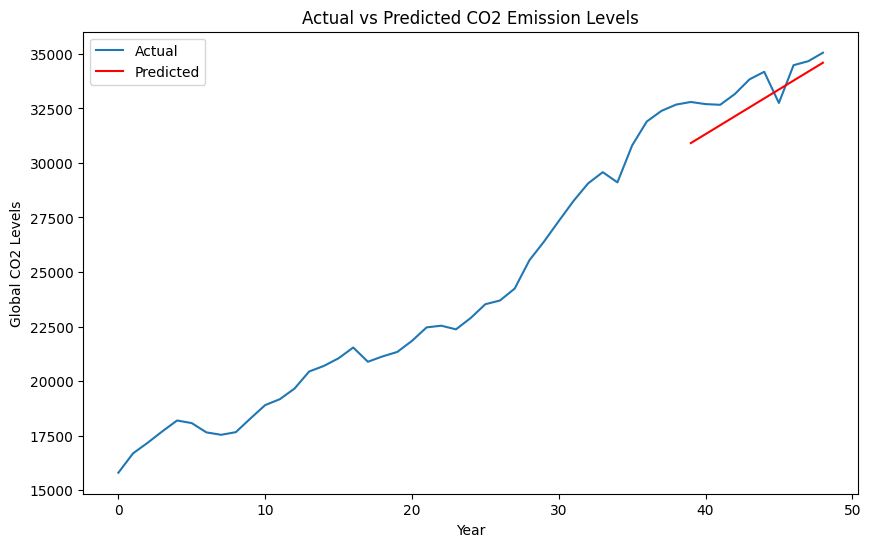

In [48]:
# Plotting the actual vs predicted values inorder to visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(df_global.index, df_global['co2'], label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted CO2 Emission Levels')
plt.xlabel('Year')
plt.ylabel('Global CO2 Levels')
plt.legend()
plt.show()

This chart shows that the model is not a good predictor for CO" levels over time and is likely to underestimate future values.<br>
This suggests that CO2 emissions are more complex than a simple regression model can manage.

### Create the linear regression pipeline
This function creates a pipeline to perform feature scaling and feature selection before finally performing the linear regression modelling.

In [ ]:
def pipeline_linear_regression():
    """
    Returns:
        pipeline (Pipeline): The pipeline object that performs the specified steps.
    """
    pipeline = Pipeline(
        [
            ("feat_scaling", StandardScaler()),
            ("feat_selection", SelectFromModel(LinearRegression())),
            ("model", LinearRegression()),
        ]
    )

    return pipeline

pipeline_linear_regression()

Next we use the pipeline to fit the training data

In [ ]:
pipeline = pipeline_linear_regression()
pipeline.fit(X_train, y_train)

In [ ]:
def linear_model_coefficients(model, columns):
    """
    Print the intercept and coefficients of a linear model.

    Parameters:
    model (object): The trained linear model object.
    columns (array-like): The column names corresponding to the coefficients.

    Returns:
    None
    """
    print(f"* Interception: {model.intercept_}")
    coeff_df = pd.DataFrame(model.coef_, columns, columns=["Coefficient"]).sort_values(
        ["Coefficient"], key=abs, ascending=False
    )
    print("* Coefficients")
    print(coeff_df)


In [ ]:
linear_model_coefficients(
    model=pipeline['model'],
    columns=X_train.columns[pipeline['feat_selection'].get_support()])

In [ ]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Gets Train and Test set (features and target), pipeline, and adjusts dots transparency
    at scatter plot.

    Parameters:
    - X_train (array-like): Training set features.
    - y_train (array-like): Training set target.
    - X_test (array-like): Test set features.
    - y_test (array-like): Test set target.
    - pipeline (object): Trained regression pipeline.
    - alpha_scatter (float, optional): Transparency level for scatter plot dots. Default is 0.5.

    Returns:
    None

    Functionality:
    - Predicts on the train and test set using the provided pipeline.
    - Creates Actual vs Prediction scatterplots for the train and test set.
    - Draws a red diagonal line. In theory, a good regressor should predict
        close to the actual, meaning the dot should be close to the diagonal red line.
        The closer the dots are to the line, the better.
    - Displays the scatterplots.
    """
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color="red", ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color="red", ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(
    X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5
)

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.